# 2019 Winter STAT 231B Homework 4: XGBoost
In this assignment, you will implement xgboost for an email spam dataset. This dataset has 57 continuous predictors and 1 nominal class label, {0, 1}. 
- Use negative log-likelihood loss with label {0, 1}.
- You don't need to consider regularization for the xgboost. However we ask you to grow a tree with `sklearn.tree.DecisionTreeRegressor`. It allows you to set parameter `min_impurity_decrease` which is somewhat equivalent to regularize the number of trees in a model. For more details, see https://xgboost.readthedocs.io/en/latest/tutorials/model.html. If you don't understand the equivalance, that's fine. Just implement xgboost without regularization and grow a tree with tuning in `min_impurity_decrease` parameter for `sklearn.tree.DecisionTreeRegressor`. Of course, you can implement a regression function to grow a tree by yourself. Then it's convenienent to do any regularization for xgboost, which is not reuqired for this homework.
- Please follow the notebook to fill in the code required in four parts.
- The output we would like to see is a plot of cross-valition accuracy as a function of hyparameters and the accuracy of the testing data. If you implement the regression tree function by yourself instead of using `sklearn.tree.DecisionTreeRegressor`, just plot the accuracy over the hyperparameters you define.
- Please complete this notebook and print it out as pdf for submission. Submit 2 files, one pdf and one python files (python file need fill only boost class and cross_validation function).

#### By Ruchen Zhen, UID: 205036408, 2019/02/26

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D

# load data 
data = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header=None)
p_ = data.shape[1]
p = p_ - 1
X = data.iloc[:, :p]
y = data.iloc[:, p]

# split the data to training set and testing test
# the training set will be used to choose hyperparameters
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values



## XGBoost Implementation
Define a function or class to implement the xgboost. To grow a tree, you can `sklearn.tree.DecisionTreeRegressor` directly. It allows you to set sample_weight which comes handy for growing a tree in xgboost since each step 
of xgboost is essentially building a regression tree with sample weight. 'sklearn.tree.DecisionTreeRegressor' also enables you to set `min_impurity_decrease` (A node will be split if this split induces a decrease of the impurity greater than or equal to this value.). Please use this parameter to control the complexity of the tree. This parameter is considered as a hyperparameter for our boosting model. The number of trees of the boosting model, M, is also considered as a hyperparameter.


In [303]:
# define a function or class to implement the xgboost here
#########################################################
# fill in code here

'''
Train roadmap: 
    Initialize the "parameter", i.e. the score, the cumulating score of all trees, to be zero (or some other value, does not matter)
    for every tree:
        1. cross entropy loss (Attention!!! Here we use the score obtained in the last iteration (for the first iteration is the initial value). )
            Remember, in each iteration, we predict using the current model we have now, i.e. all tree growed before this iteration, i.e. the score, and therefore the loss. 
            So in this iteration, we grow a tree to fit the loss, but this model is used for the next iteration. 
        2. get the first, second order dirivative: of Loss w.r.t. score
        3. calclate: label, weight for training the tree in this iteration, by using the first and second derivative
        4. Fit a Regression Tree by using the data (X_train always) and the label, weight for this iteration
        5. Update the score, i.e. the addition of all trees, the parameter!!! by adding the score produced by the CART growed in this iteration
        6. Something for next training: (1) X_train, y_train always the same, (2) Updated model
'''


'''
Major mistakes I made:
    1. Score used for this iteration should be the cumulation before this iteration. 
        - If set the initail score (i.e. model, or saying "parameter") to be zero, in the first iteration, the score is zero.
          Thus probability of both 1 and 0 is one half. 
          Thus we have a Loss(score_this_iteration, y_truth). 
          Thus we have gradient and hessian of Loss w.r.t. score. 
          Thus have the label and weight for **the tree to learn this iteration**
    2. Grow a tree at the begining of the iteration. Instead it should be in the end of the iteration. 
    3. What is the output for each iteration. Instead of X_train and y_train will be used for all iterations, all next iteration need from this iteration, 
       is the updated model with a new CART added. Weight and label which updated every iteration is only used for grow a CART this iteration. 
'''

"""
The overflow Problem: 
    When calculating residual = -gradient/hessian, hessian is extremely small and gradient is kind of large, thus residual will be extremely large and overflow. 
    Solution: add a small value eps --> residual = -gradient/(hessian + eps)
"""

class XGBOOST():
    def __init__(self, min_impurity_decrease=0.01, M=5):
        self.min_impurity_decrease = min_impurity_decrease
        self.M = M
        self.CARTs = []

    def training(self, train_features, train_labels):
        n = train_features.shape[0]
        # running_weights = None
        # running_labels = train_labels
        score = np.zeros_like(train_labels, dtype=float)
        
        eps = 1e-2 # small number to prevent dividing by zero
        sigmoid = lambda score: 1/(1+np.exp(-score))
        
        for i in range(self.M):
            '''print('')
            print('***Training the ' + str(i+1) + 'th Tree......')
            print('')
            
            print('score for this iteration (Cumulation of all trees growed before this iteration): ')
            print(score.shape, score)
            print('Residual: ')
            print(train_labels - sigmoid(score))'''
            
            
                        
            # Accuracy
            y_pred = np.zeros_like(train_labels)
            for i in range(len(train_labels)): 
                if score[i] > 0: 
                    y_pred[i] = 1
            # from sklearn.metrics import accuracy_score
            # print(accuracy_score(train_labels, y_pred))
            '''print('Accuracy: ')
            print(np.sum(y_pred == train_labels)/len(y_pred))'''
            
            # Logistic Loss
            Loss = np.sum(train_labels * np.log(1 + np.exp(-score)) + (1 - train_labels) * np.log(1 + np.exp(score)))
            '''print('Loss: ')
            print(Loss.shape, Loss)'''
            
            # Derivative of L1 respect to s1: first order and second order
            #gradient = -train_labels * np.exp(-score) / (1 + np.exp(-score)) + (1-train_labels) * np.exp(score) / (1 + np.exp(score))
            #hessian = (-train_labels) * (-np.exp(-score) * (1 + np.exp(-score)) + np.exp(-2*score)) / (1 + np.exp(-score))**2 + (1-train_labels) * (np.exp(score)*(1+np.exp(score)) - np.exp(2*score)) / (1+np.exp(score))**2
            
            gradient = (1-train_labels) - 1/(1+np.exp(score))
            hessian = np.exp(score)/(1+np.exp(score))**2
            
            '''print('gradient: ')
            print(gradient.shape, gradient)
            print('hession: ')
            print(hessian.shape, hessian)'''
            
            # New label and weight
            residual = -gradient/(hessian + eps)
            running_weights = hessian
            '''print('y_new: ')
            print(residual.shape, residual)
            print('weight_new: ')
            print(running_weights.shape, running_weights)'''
            
            cart = DecisionTreeRegressor(random_state=0, min_impurity_decrease = self.min_impurity_decrease)
            
            # fit(X, y, sample_weight=None)
            cart.fit(train_features, residual, sample_weight=running_weights)
            
            # Add the score obtained by the CART growed this iteration, to make the new model, i.e. the score for next iteration
            score += cart.predict(train_features)
            
            self.CARTs.append(cart)
            
            

        

    def testing(self, test_features, test_labels):
        '''print('')
        print('Testing...')
        print('')'''
        scores = np.zeros_like(test_labels, dtype=float)
        for i in range(self.M):
            cart = self.CARTs[i]
            cart_pred = cart.predict(test_features)
            scores += cart_pred
            
        test_pred = np.zeros_like(test_labels)
        for i in range(len(test_labels)): 
            if scores[i] > 0: 
                test_pred[i] = 1
        
        accuracy = np.sum(test_pred == test_labels)/len(test_labels)
        '''print('Accuracy: ')
        print(accuracy)'''
        return accuracy
        

#########################################################



## Cross Validation
Define a function to do cross-validation to search for hyperparameter values with training set and the xgboost implementation above. This function has three input parameters. 1. log_min_impurity_decreases: a list consists of min_impurity_decrease on a log scale. 2. Ms: a list consists of the number of trees that a boosting model has. 3. n_splits: the folds for cross-validation. The purpose of the function is to tune in min_impurity_decrease and M. To choose hyperparameters we use data (X_train, y_train).

This function returns three objects:
- 1 plot_values is a numpy.array with three columns where the first column is log_min_impurity_decrease, the second column is M, and the third column is the corresponding mean accuracy of each cross-validation
- 2 best_log_min_impurity_decrease: the best log_min_impurity_decrease
- 3 best_M: the best M
- best_log_min_impurity_decrease and best_M are determined by the highest average accuracy


In [297]:
def cross_validation(log_min_impurity_decreases, Ms, n_splits=5):
    #########################################################
    # fill in code here
    # log_min_impurity_decreases: type: list
    # Ms: type: list
    
    foldsize = int(y_train.shape[0] / n_splits)
    plot_values = np.zeros((3, len(log_min_impurity_decreases)*len(Ms)))
    count = 0
    

    for log_min_impurity_decrease in log_min_impurity_decreases: 
        for M in Ms:
            mean_accuracy_per_parameter = 0
            for i in range(1, n_splits+1):
                xgb = XGBOOST(min_impurity_decrease=np.exp(log_min_impurity_decrease), M=M)
                '''Had bug when i = 0! could not add the array X_train[:0]'''
                '''Found array with 0 sample(s) (shape=(0, 57)) while a minimum of 1 is required.'''
                if i == 0:
                    xgb.training(X_train[i*flodsize: , :], y_train[i*flodsize:])
                    accuracy_temp = xgb.testing(X_train[:i*foldsize, :], y_train[:i*foldsize])
                elif i == n_splits - 1:
                    xgb.training(X_train[:(i-1)*foldsize, :], y_train[:(i-1)*foldsize])
                    accuracy_temp = xgb.testing(X_train[(i-1)*foldsize:, :], y_train[(i-1)*foldsize:])
                else:
                    xgb.training(np.vstack((X_train[:(i-1)*foldsize, :] , X_train[i*foldsize:, :])), np.concatenate((y_train[:(i-1)*foldsize] , y_train[i*foldsize:])))
                    accuracy_temp = xgb.testing(X_train[(i-1)*foldsize : i*foldsize, :], y_train[(i-1)*foldsize : i*foldsize])
                               
                mean_accuracy_per_parameter += accuracy_temp                
            
            mean_accuracy_per_parameter /= n_splits
            plot_values[:, count] = np.array([log_min_impurity_decrease, M, mean_accuracy_per_parameter])
            count += 1
            

    best_index = np.argmax(plot_values[2,:])
    best_log_min_impurity_decrease = plot_values[0, best_index]
    best_M = plot_values[1, best_index]
    plot_values = plot_values.T



    #########################################################
    return plot_values, best_log_min_impurity_decrease, best_M




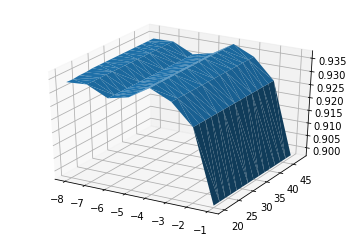

In [298]:
log_min_impurity_decreases = list(range(-8, 0))
Ms = list(range(20, 50, 2))
plot_values, best_log_min_impurity_decrease, best_M = cross_validation(log_min_impurity_decreases=log_min_impurity_decreases, Ms=Ms)

# plot the accuracy over the hyperparameter values
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(plot_values[:, 0], plot_values[:, 1], plot_values[:, 2], linewidth=0.2, antialiased=True)
plt.show()


In [299]:
print('Best hyperparameters...')
print('Best log min impurity decrease: ', best_log_min_impurity_decrease)
print('Best M (max # of trees): ', best_M)

Best hyperparameters...
Best log min impurity decrease:  -4.0
Best M (max # of trees):  20.0


## Fit the training data with the chosen hyperparameters
Use data (X_train, y_train)




In [301]:
#########################################################
# fill in code here
xgb = XGBOOST(min_impurity_decrease=np.exp(best_log_min_impurity_decrease), M=int(best_M))
xgb.training(X_train, y_train)
training_accuracy = xgb.testing(X_train, y_train)

print('Training accuracy (with best hyperparameter): ', training_accuracy)

#########################################################



Training accuracy (with best hyperparameter):  0.9980978260869565


## Print the testing accuracy with the chosen models
Use data (X_test, y_test)

In [302]:
#########################################################
# fill in code here
testing_accuracy = xgb.testing(X_test, y_test)
print('Testing accuracy (with best hyperparameter): ', testing_accuracy)

#########################################################



Testing accuracy (with best hyperparameter):  0.9305103148751357
